In [103]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [7]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

# How well do moments enforce model structure?

While testing it was found that for detecting interaction moment constraints + CME constraints produced identical results to simply moment constraints with dummy variables:

\begin{align*}
    \sum_{x_{1} = 0}^{max_1} x p_{1}(x) &\in \mathbb{E}[X_{1}] \text{ CI } &\iff y &\in \mathbb{E}[X_{1}] \text{ CI } \\
    \sum_{x_{2} = 0}^{max_2} x p_{2}(x) &\in \mathbb{E}[X_{2}] \text{ CI } &z &\in \mathbb{E}[X_{2}] \text{ CI } \\
    \left(\sum_{x_{1} = 0}^{max_1} x p_{1}(x) \right) \left(\sum_{x_{2} = 0}^{max_2} x p_{2}(x) \right) &\in \mathbb{E}[X_{1}X_{2}] \text{ CI }  &y * z &\in \mathbb{E}[X_{1}X_{2}] \text{ CI }\\

    \textbf{ + CME constraints}
    
\end{align*}

Since the moment constraints did not give enough information about the probabilities for the CME to enforce the model structure e.g. taking non-poisson data from an independent telegraph model and inputting the moments together with a birth-death CME was always* feasible

## Code

Optimize using moment constraints (1st and optional 2nd moment) and CME for a birth death model.

Bound moment expressions in interval of width delta about the true value

In [284]:
def optimize_moment(M, k, a, b, delta, gamma=0.0, silent=True, printing=True, time_limit=300, var=False):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (delta / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (delta / 2)
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OG)
            expr_EX_OG = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OG = gp.quicksum(p * np.arange(M + 1)**2)

            # expressions for moments (OB)
            expr_EX_OB = expr_EX_OG * Ebeta
            if var:
                expr_EX2_OB = expr_EX2_OG*Ebeta2 + expr_EX_OG*(Ebeta - Ebeta2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

## Perfect information gives Perfect results?

Only when using 2nd moment

In [285]:
print("1st Moment:")
solution = optimize_moment(M=100, k=2, a=1, b=20, delta=0.0, silent=True, var=False)
print("1st and 2nd Moments:")
solution = optimize_moment(M=100, k=2, a=1, b=20, delta=0.0, silent=True, var=True)

1st Moment:
k_tx in (2.0, 100.0), status OPTIMAL, OPTIMAL
1st and 2nd Moments:
k_tx in (2.0, 2.0), status OPTIMAL, OPTIMAL


When given the exact moment values ($\delta$=0) the 1st moment only gives an exact lower bound on $k$ but does not give an upper bound (limited to a fixed $K = 100$). Adding the 2nd moment gives exact lower and upper bounds on $k$.

This holds even for low capture efficiencies e.g $\beta \sim \text{Beta}(1, 20)$

## Impact of $\delta$ and $\mathbb{E}[X^{2}]$

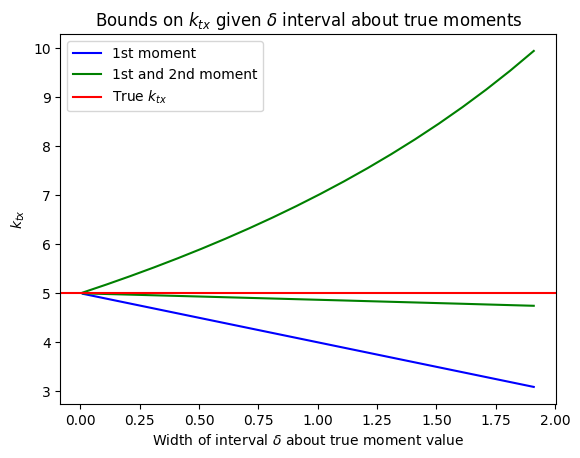

In [286]:
deltas = [0.01 + d/10 for d in range(20)]
k = 5
M = 100
a = 1
b = 1
lbs_moment = []
ubs_moment = []
lbs_moment_var = []
ubs_moment_var = []
for delta in deltas:
    solution_moment = optimize_moment(M, k, a, b, delta, printing=False, var=False)
    solution_moment_var = optimize_moment(M, k, a, b, delta, printing=False, var=True)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])
    lbs_moment_var.append(solution_moment_var['min'])
    ubs_moment_var.append(solution_moment_var['max'])
plt.title(r"Bounds on $k_{tx}$ given $\delta$ interval about true moments")
plt.xlabel(r"Width of interval $\delta$ about true moment value")
plt.ylabel(r"$k_{tx}$")
plt.plot(deltas, lbs_moment, color="blue", label="1st moment")
plt.plot(deltas, lbs_moment_var, color="green", label="1st and 2nd moment")
# plt.plot(deltas, ubs_moment, color="blue")
plt.plot(deltas, ubs_moment_var, color="green")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

As $\delta$ increases from $0$ (width of input bounds) so does the width of the output bounds

The lower bound for 1st and 2nd moment optimization scales better with $\delta$ than 1st moment alone, although both are appear linearly related. The upper bound for 1st and 2nd moments appears quadratically related to $\delta$ and scales worse than the lower bound (and even lower bound for 1st moment alone)

NOTE: upper bound for optimization using just the 1st moment not shown as is constant 100

## Impact of capture efficiency $\beta$

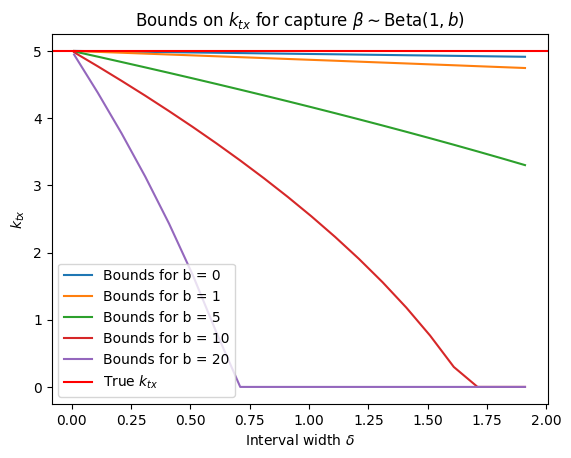

In [288]:
# settings
deltas = [0.01 + d/10 for d in range(20)]
k = 5
M = 100
a = 1
bs = [0, 1, 5, 10, 20]

# plot
plt.title(r"Bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for b in bs:
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment(M, k, a, b, delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(deltas, lbs_moment, label=f"Bounds for b = {b}")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

At higher capture efficiencies (blue, orange) the lower bound scales well with $\delta$, still giving reasonably tight bounds on $k$. However, for lower capture (green, red) the bound drops off fast, and for the lowest (purple, used for real data) after a width of $\sim 0.75$ $k$ is not constrained at all.

For all capture distributions the bounds scale (roughly) linearly with $\delta$

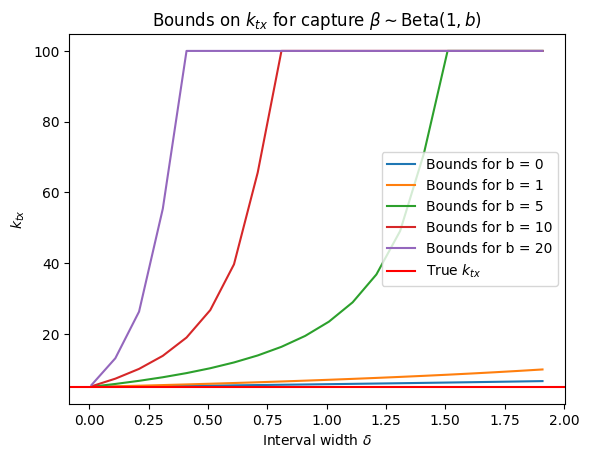

In [290]:
# settings
deltas = [0.01 + d/10 for d in range(20)]
k = 5
M = 100
a = 1
bs = [0, 1, 5, 10, 20]

# plot
plt.title(r"Bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for b in bs:
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment(M, k, a, b, delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(deltas, ubs_moment, label=f"Bounds for b = {b}")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()


At higher capture efficiencies (blue and orange) the upper bound scales slowly with $\delta$, but still becomes relatively large. For lower capture efficiencies the scaling is even worse, and bounds rapidly reach the manuallly set limit $K = 100$, providing no constraints at all.

For all capture distributions the bounds appear to scale quadratically with $\delta$.

## Impact of non-poisson data

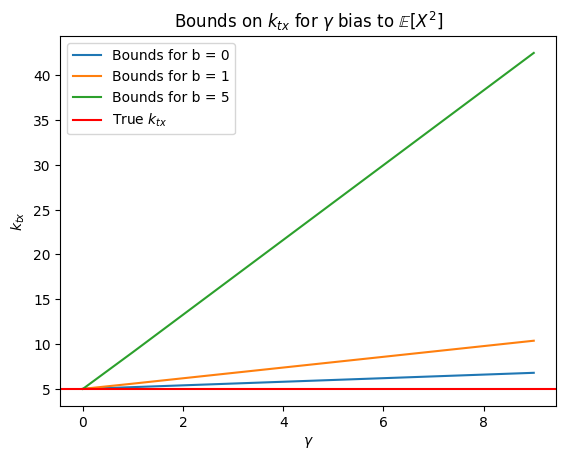

In [293]:
# settings
delta = 0.01
gammas = [g for g in range(10)]
k = 5
m = 100
a = 1
bs = [0, 1, 5]

# plot
plt.title(r"Bounds on $k_{tx}$ for $\gamma$ bias to $\mathbb{E}[X^{2}]$")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$k_{tx}$")

# run
for b in bs:
    lbs_moment = []
    ubs_moment = []
    for gamma in gammas:
        solution_moment = optimize_moment(M, k, a, b, delta, gamma, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(gammas, lbs_moment, label=f"Bounds for b = {b}")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

In [295]:
solution_moment = optimize_moment(20, 5, 1, 0, 0.01, -1, printing=True, silent=True, time_limit=60, var=True)

k_tx in (None, None), status INFEASIBLE, INFEASIBLE


Infeasible when 2nd moment smaller than 1st moment, but when 2nd moment larger the optimization is still feasible but the resulting bounds do not contain the true parameter value

## Comparison to probabilities

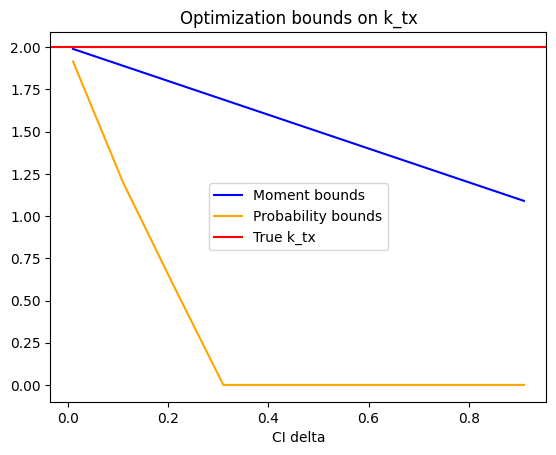

In [190]:
deltas = [0.01 + d/10 for d in range(10)]
k = 2
m = 20
lbs_moment = []
ubs_moment = []
lbs_probs = []
ubs_probs = []
for delta in deltas:
    solution_moment = optimize_moment(m, k, delta, silent=True, printing=False, var=False)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])
    solution_probs = optimize_probability(m, k, delta, silent=True, printing=False)
    lbs_probs.append(solution_probs['min'])
    ubs_probs.append(solution_probs['max'])
plt.title("Optimization bounds on k_tx")
plt.xlabel("CI delta")
plt.plot(deltas, lbs_moment, color="blue", label="Moment bounds")
#plt.plot(deltas, ubs_moment, color="blue")
plt.plot(deltas, lbs_probs, color="orange", label="Probability bounds")
#plt.plot(deltas, ubs_probs, color="orange")
plt.axhline(k, color="red", label="True k_tx")
plt.legend()

BUT unfair comparison? as confidence interval width will be related to value, and moments are typically larger values than probabilities (which are in [0, 1] and often small)

Need to find typical ranges of CI width to assess

## Old code

In [ ]:
def optimize_moment_old(M, k, delta, silent=True, printing=True, time_limit=300, var=False):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
            E_x = model.addVar(vtype=GRB.CONTINUOUS, name="E_x")
            if var: E_x_2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x_2")

            # constraints

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # moments
            expr_E_x = gp.quicksum(p * np.arange(M + 1))
            if var: expr_E_x_2 = gp.quicksum(p * np.arange(M + 1)**2)

            model.addConstr(E_x == expr_E_x, name="E_x_equality")
            if var: model.addConstr(E_x_2 == expr_E_x_2, name="E_x_2_equality")

            model.addConstr(E_x <= k + delta, name="E_x_UB")
            model.addConstr(E_x >= k - delta, name="E_x_LB")
            
            if var: model.addConstr(E_x_2 <= k + k**2 + delta, name="E_x_2_UB")
            if var: model.addConstr(E_x_2 >= k + k**2 - delta, name="E_x_2_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]
            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

In [ ]:
def optimize_probability(M, k, delta, silent=True, printing=True, time_limit=300):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # constraints

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # probabilities
            probs = scipy.stats.poisson.pmf(np.arange(M + 1), k)
            model.addConstr(p <= probs + delta, name="p_UB")
            model.addConstr(p >= probs - delta, name="p_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]
            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution